In [33]:
import json, pprint
import csv
from sets import Set
import numpy as np
import utils
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

### create 3 month offline data .json file
- change Date to Epoch, change json to list
- input: dedup_FP_2018_05_2018_07.json file from Xiao
- output: featurePool3months.json for one training

In [3]:
def is_json(myjson):
    try:
        json_object = json.loads(myjson)
    except ValueError, e:
        return False
    return True

In [5]:
with open('dedup_FP_2018_05_2018_07.json') as f:
    lines = f.readlines()

In [6]:
pattern = '%Y-%m-%d %H:%M:%S'
jsonstr = "["
for l in lines: 
    l = l.strip();
    if is_json(l):
        data = json.loads(l)
        date_time = data['created_at'][:-5]
        epoch = int(time.mktime(time.strptime(date_time, pattern)))
        data['created_at'] = epoch
        
        date_time = data['report_created_at'][:-5]
        epoch = int(time.mktime(time.strptime(date_time, pattern)))
        data['report_created_at'] = epoch
        
        jsonstr = jsonstr + json.dumps(data) + ','
        #print json.dumps(data)
jsonstr = jsonstr[0:-1]+"]"

In [7]:
text_file = open("featurePool3months.json", "w")
text_file.write(jsonstr)
text_file.close()

In [8]:
!hostname

dswa002-dca1


In [9]:
pwd

u'/mnt/cephfs/hadoop-compute/phoenix/ting/wisdom'

### load matched, unmatch feature lists
- matched_feature.txt and unmatched_feature.txt are created from calculatededuptrainingdatahandler in java

In [15]:
matchData = []
with open("matched_feature.txt") as f:
    for line in f:
        row = line[1:-2].split(",")
        row = [float(i) for i in row]
        matchData.append(row) 

In [16]:
unmatchData = []
with open("unmatched_feature.txt") as f:
    for line in f:
        row = line[1:-2].split(",")
        row = [float(i) for i in row]
        unmatchData.append(row) 

In [17]:
len(matchData)

858

In [18]:
len(unmatchData)

2466

## offline training and save config to file
- need to manually write config to similarityScoreModel.json

In [19]:
from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve,average_precision_score

In [20]:
X_sim_train = np.array(matchData[0:810])
X_sim_test = np.array(matchData[810:-1])

X_random_train = np.array(unmatchData[0:2400])
X_random_test = np.array(unmatchData[2400:-1])

In [21]:
X_train = np.vstack((X_sim_train, X_random_train))
X_test = np.vstack((X_sim_test, X_random_test))

labels_train = np.hstack((np.ones(X_sim_train.shape[0]), np.zeros(X_random_train.shape[0])))
y_train = labels_train.astype(int)

labels_test = np.hstack((np.ones(X_sim_test.shape[0]), np.zeros(X_random_test.shape[0])))
y_test = labels_test.astype(int)
print y_train.shape, y_test.shape

#X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=0)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

(3210,) (112,)


In [22]:
lrcf = LogisticRegression()
lrcf.fit(X_train_transformed, y_train)
lrcf.score(X_test_transformed, y_test)

0.8125

In [23]:
lrcf.coef_

array([[ 0.1536275 ,  4.28654945,  1.13025461, -0.91988431, -0.26615507,
         0.76599478,  0.20892183,  0.29011837,  0.01945118,  0.        ,
        -0.20530868, -0.30845651,  0.18226364]])

In [24]:
lrcf.intercept_

array([-0.3345596])

In [25]:
scaler.scale_

array([  4.48438097e-01,   2.62676113e-01,   3.80566084e-01,
         2.12994448e+06,   2.15026400e-01,   3.06934379e-01,
         5.57275508e-02,   3.84757274e-01,   3.49426770e-01,
         1.00000000e+00,   4.60136422e-01,   4.11436856e-01,
         4.44810944e-01])

In [26]:
scaler.mean_

array([  2.86872075e-01,   8.42405366e-02,   1.88675420e-01,
         2.32441491e+06,   4.85981308e-02,   1.05295950e-01,
         9.96884735e-01,   1.80685358e-01,   1.42367601e-01,
         1.00000000e+00,   3.04361371e-01,   2.15887850e-01,
         7.28348910e-01])

#### unit test data sample for scaler

In [27]:
X_train[20]

array([  7.27272727e-02,   4.00000000e-02,   1.00000000e+00,
         1.61743800e+06,   0.00000000e+00,   0.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
         1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

In [28]:
X_train_transformed[20]

array([-0.47753481, -0.16842238,  2.13188882, -0.33192269, -0.22601007,
       -0.34305688,  0.0559017 ,  2.1294325 , -0.40743187,  0.        ,
       -0.66145899, -0.52471685, -1.63743478])

#### unit test data sample for logistic regression prediciton 

In [36]:
lrcf.predict_proba(X_train_transformed[20])

/home/udocker/phoenix-worker/environments/python2/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.11887144,  0.88112856]])

---

Average precision-recall score: 0.93


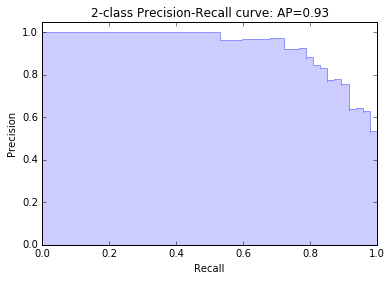

In [34]:
y_score = lrcf.decision_function(X_test_transformed)
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))